In [1]:
from src.dataset import SexPredDataset
from src.sexpred import SexPred
from src.train import trainIters

import torch,gensim

DATASET_LOCATION="/home/andres/COMP6321_machine_learning/data/dataset.xml"
PERVS_LOCATION="/home/andres/COMP6321_machine_learning/data/pervs.txt"
EMBEDDINGS_LOCATION="/home/andres/COMP6321_machine_learning/embeddings.bin"

ds=SexPredDataset(DATASET_LOCATION,PERVS_LOCATION,embeddings_file=EMBEDDINGS_LOCATION)
test_size=int(0.2*len(ds))
valid_size=int(0.1*len(ds))
train_size=len(ds)-test_size-valid_size
train_ds,valid_ds,test_ds=torch.utils.data.random_split(ds,(train_size,valid_size,test_size))

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
emb=gensim.models.KeyedVectors.load_word2vec_format(EMBEDDINGS_LOCATION,binary=True)
emb_tensor=torch.FloatTensor(emb.vectors)

## CONFIG
#########
batch_size=64
epochs=30
learning_rate=1e-3
hidden_size=512
#########
## END CONFIG

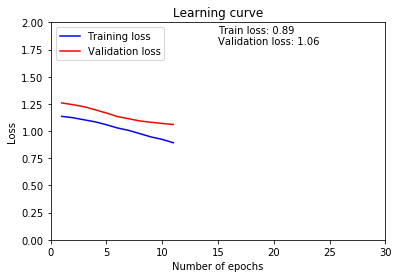

In [ ]:
model=SexPred(emb_tensor,hidden_size=hidden_size).to(device)
train_losses,valid_losses=trainIters(model,train_ds,valid_ds,batch_size,epochs,learning_rate)

In [10]:
# model = torch.load("/home/andres/COMP6321_machine_learning/P-1000")
model

SexPred(
  (encoder): Encoder(
    (embedding): Embedding(38775, 100)
    (gru): GRU(100, 512, num_layers=3, batch_first=True, dropout=0.5)
  )
  (decoder): Decoder(
    (embedding): Embedding(38775, 100)
    (gru): GRU(100, 512, num_layers=3, batch_first=True, dropout=0.5)
    (out): Linear(in_features=512, out_features=38775, bias=True)
  )
)

In [ ]:
from src.train import valid
from tqdm import tqdm_notebook as tqdm

def evaluate(model,test_set):
    """returns perplexity of model"""
    loss_avg=[]
    model.eval()
    test_dl = torch.utils.data.DataLoader(test_set,batch_size=16)
    criterion=torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        for x,y in tqdm(test_dl,desc="Testing",leave=False):
            input_tensor=x.to(device)
            target=y.to(device)
            loss,_=valid(input_tensor,target,model,criterion)
            loss_avg.append(loss)
        loss_avg=sum(loss_avg)/len(loss_avg)
    return 2**loss_avg

evaluate(model,test_ds)

In [ ]:
emb.index2word[61]

In [11]:
def predict(input_,model=model):
    encoder=model.encoder
    decoder=model.decoder
    hidden=encoder.initHidden(1).to(device)
    _,hidden=encoder(input_,hidden)
    pred=torch.tensor([[1]]).to(device)
    token=pred.item()                   
    pred_sent=[]
    while token!=0:
        pred,hidden=model.decoder(pred,hidden)
#         print(pred.max(-1)[1])
        pred=pred.max(-1)[1]
        token=pred.item()
        pred_sent.append(pred)
    return torch.tensor(pred_sent)

responses=[]
for n in tqdm(range(len(train_ds)),desc="Predicting"):
    sample=train_ds[n]
    x=sample[0].unsqueeze(0).to(device)
    if predict(x)[0].item()!=0:
        responses.append((x,predict(x)))
# s=s[:,:1]
# s.shape
# RoboPerv.decoder(s,h)

In [12]:
responses=[[x.squeeze(),y] for x,y in responses]
responses=[[x.tolist(),y.tolist()] for x,y in responses]

In [13]:
for index,t in enumerate(responses):
    x=t[0]
    new_x=[]
    for n in x:
        if n!=0: new_x.append(n)
    responses[index][0]=new_x

In [14]:

for i in range(294):
    v=responses[i][0][1:]
    p=responses[i][1][:-1]
    v = [emb.index2word[w] for w in v]
    p = [emb.index2word[w] for w in p]
    print(" ".join(v)," : "," ".join(p))

k hang on  :  ok
good im walkin w a cane now cuz was hurtin me  :  ok
waht ya doin  :  nothing
hi  :  how r u
she made calls go micky cell that way calls me after sheesh im still grounded  :  ok
k i called ethan times today and he did not call back  :  ok
sry brb  :  ok
i dunno gess well see when u get here lol  :  ok
how was ur  :  hot
lol i guess do u have any  :  yes
hi  :  how r u
do u want me  :  yes
k thats cool lol  :  ok
k lol its easy to find  :  ok
we talked on the phone an all now yur actin wierd  :  yea i was a little bit
lol im gonna tickle  :  ok
no its lil white thing that like clips on  :  ok
rofl brb i gotta pee  :  ok
ull feel better wen u c me ill say hi joe lol  :  ok
playin poppit r u still walkin  :  ok
i do know where i live yeah r u gonna tell me what gonna  :  i do
he had like tons of they got all this shyt but i got nothin  :  why
cos i was waiting for u didja miss  :  no
whatevr i aint messin wit ya so jus forget it  :  ok
idk he said hed call he said like be